## First I will download all the dependencies that we will need

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported successfully.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         395 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5

## Download and Export Dataset

As stated the dataset has already been located as a .json file so I will download the dataset using wget command.

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data loaded successfully')

Data loaded successfully


Now, I will load the data and explore the data

In [3]:
with open('newyork_data.json') as json_data:
    newyorkcity_data = json.load(json_data)

In [4]:
newyorkcity_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

We can notice that all data is in features key, so I will define a new key that contains the features variable only.

In [5]:
newyork_features=newyorkcity_data['features']
newyork_features[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

## Tranforming this data into a pandas dataframe

I will tranform this data into a pandas dataframe. For that step I will first create an empty dataframe and then load the newyork_features data into it.

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork_boroughs = pd.DataFrame(columns=column_names)
newyork_boroughs

,Borough,Neighborhood,Latitude,Longitude


Lets load newyork_features data in this dataframe now

In [7]:
for data in newyork_features:
    borough = data['properties']['borough'] 
    newyork_name = data['properties']['name']
        
    newyork_latlon = data['geometry']['coordinates']
    newyork_lat = newyork_latlon[1]
    newyork_lon = newyork_latlon[0]
    
    newyork_boroughs = newyork_boroughs.append({'Borough': borough,
                                          'Neighborhood': newyork_name,
                                          'Latitude': newyork_lat ,
                                          'Longitude': newyork_lon}, ignore_index=True)

In [8]:
newyork_boroughs.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


We have to make sure that the dataframe contains five boroughs

In [9]:
print('The dataframe has {} boroughs.'.format(
        len(newyork_boroughs['Borough'].unique())
    )
)

The dataframe has 5 boroughs.


## Using Geopy Library to get Longitude and Latitude of New York City

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


## Creating a map of New York using Folium library

In [11]:
# create map of New York using latitude and longitude values
newyork_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(newyork_boroughs['Latitude'], newyork_boroughs['Longitude'], newyork_boroughs['Borough'], newyork_boroughs['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(newyork_map)  
    
newyork_map

The above map shows the boroughs and neighborhoods of New York City. We will use this data to compare the amount of Italian restaurants in Manhattan.

## I. Exploring Manhattan

I will start with exploring Manhattan and create a new dataframe manhattan_df where I will slice the original dataframe newyork_boroughs

In [12]:
manhattan_df = newyork_boroughs[newyork_boroughs['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


### Getting geographical coordinates of Manhattan

In [13]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


### Visualizing the map of Manhattan 

In [14]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_df['Latitude'], manhattan_df['Longitude'], manhattan_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

## Loading Foursqure Credentials

In [15]:
CLIENT_ID = 'RBJ1ZXNLLVUWAW1F5HCZEOTNODCMA10LKVIBHUN0GOKOXZHC' # your Foursquare ID
CLIENT_SECRET = '4QKW0DHRXDOSDNL2QHYKPWTDCHLIQA5F4RMIE0RWBHS33XLI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RBJ1ZXNLLVUWAW1F5HCZEOTNODCMA10LKVIBHUN0GOKOXZHC
CLIENT_SECRET:4QKW0DHRXDOSDNL2QHYKPWTDCHLIQA5F4RMIE0RWBHS33XLI


She stays in this area and will use the address to conduct the analysis in Manhattan

In [16]:
address = '33 W 55th St, New York, NY'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.762496150000004 -73.97639335979032


### I will run a query for Italian restaurants in the area first

In [17]:
search_query = 'Italian'
radius = 500
print(search_query + ' .... OK!')

Italian .... OK!


Define the corresponding URL

In [18]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius)
url

'https://api.foursquare.com/v2/venues/search?client_id=RBJ1ZXNLLVUWAW1F5HCZEOTNODCMA10LKVIBHUN0GOKOXZHC&client_secret=4QKW0DHRXDOSDNL2QHYKPWTDCHLIQA5F4RMIE0RWBHS33XLI&ll=40.762496150000004,-73.97639335979032&v=20180605&query=Italian&radius=500'

Sednding Get request to obtain and examine the result

In [19]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5edd828fdf2774001b54e60c'},
 'response': {'venues': [{'id': '51e7310c498e639ed27062b1',
    'name': 'Quality Italian',
    'location': {'address': '57 W 57th St',
     'crossStreet': 'at 6th Ave',
     'lat': 40.76451329448865,
     'lng': -73.97682710066374,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.76451329448865,
       'lng': -73.97682710066374},
      {'label': 'entrance', 'lat': 40.7646, 'lng': -73.976781}],
     'distance': 227,
     'postalCode': '10019',
     'cc': 'US',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['57 W 57th St (at 6th Ave)',
      'New York, NY 10019',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d110941735',
      'name': 'Italian Restaurant',
      'pluralName': 'Italian Restaurants',
      'shortName': 'Italian',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
       'suffix': '.png'},
  

In [20]:
# assign relevant part of JSON to venues
manhattan_venues = results['response']['venues']

# tranform venues into a dataframe
venues_manhattan_df = json_normalize(manhattan_venues)
venues_manhattan_df.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,venuePage.id
0,51e7310c498e639ed27062b1,Quality Italian,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",v-1591574963,False,57 W 57th St,at 6th Ave,40.764513,-73.976827,"[{'label': 'display', 'lat': 40.76451329448865...",227,10019,US,New York,NY,United States,"[57 W 57th St (at 6th Ave), New York, NY 10019...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4e3736cab61c5cb3c37e529e,Harry's Italian Pizza Bar,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1591574963,False,30 Rockefeller Plz,NaN,40.759155,-73.979007,"[{'label': 'display', 'lat': 40.75915521536279...",432,10112,US,New York,NY,United States,"[30 Rockefeller Plz, New York, NY 10112, Unite...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50024e24e4b093944cc9f94a,Serifina Italian,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",v-1591574963,False,Broadway & 55th Street,NaN,40.764492,-73.982426,"[{'label': 'display', 'lat': 40.76449174480557...",555,10019,US,New York,NY,United States,"[Broadway & 55th Street, New York, NY 10019, U...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4f723621e4b060af19fbe3a3,Italian Government Tourist Board,"[{'id': '4f4530164b9074f6e4fb00ff', 'name': 'T...",v-1591574963,False,NaN,NaN,40.759433,-73.977502,"[{'label': 'display', 'lat': 40.75943312941940...",353,10111,US,New York,NY,United States,"[New York, NY 10111, United States]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,594a780f95da0c797e3ef3b3,Jimmi's Italian,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",v-1591574963,False,236 W 56th St,NaN,40.764267,-73.982631,"[{'label': 'display', 'lat': 40.76426695403975...",561,10019,US,New York,NY,United States,"[236 W 56th St, New York, NY 10019, United Sta...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now I will filter the Dataframe to only show the information that is important to the client

In [21]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in venues_manhattan_df.columns if col.startswith('location.')] + ['id']
venues_manhattan_df_filtered = venues_manhattan_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
venues_manhattan_df_filtered['categories'] = venues_manhattan_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
venues_manhattan_df_filtered.columns = [column.split('.')[-1] for column in venues_manhattan_df_filtered.columns]

venues_manhattan_df_filtered

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,Quality Italian,Italian Restaurant,57 W 57th St,at 6th Ave,40.764513,-73.976827,"[{'label': 'display', 'lat': 40.76451329448865...",227,10019,US,New York,NY,United States,"[57 W 57th St (at 6th Ave), New York, NY 10019...",51e7310c498e639ed27062b1
1,Harry's Italian Pizza Bar,Pizza Place,30 Rockefeller Plz,NaN,40.759155,-73.979007,"[{'label': 'display', 'lat': 40.75915521536279...",432,10112,US,New York,NY,United States,"[30 Rockefeller Plz, New York, NY 10112, Unite...",4e3736cab61c5cb3c37e529e
2,Serifina Italian,Italian Restaurant,Broadway & 55th Street,NaN,40.764492,-73.982426,"[{'label': 'display', 'lat': 40.76449174480557...",555,10019,US,New York,NY,United States,"[Broadway & 55th Street, New York, NY 10019, U...",50024e24e4b093944cc9f94a
3,Italian Government Tourist Board,Tourist Information Center,NaN,NaN,40.759433,-73.977502,"[{'label': 'display', 'lat': 40.75943312941940...",353,10111,US,New York,NY,United States,"[New York, NY 10111, United States]",4f723621e4b060af19fbe3a3
4,Jimmi's Italian,Italian Restaurant,236 W 56th St,NaN,40.764267,-73.982631,"[{'label': 'display', 'lat': 40.76426695403975...",561,10019,US,New York,NY,United States,"[236 W 56th St, New York, NY 10019, United Sta...",594a780f95da0c797e3ef3b3
5,La Vineria Ristorante Italiano,Italian Restaurant,21 W 55th St,NaN,40.761848,-73.975345,"[{'label': 'display', 'lat': 40.761848, 'lng':...",114,10019,US,New York,NY,United States,"[21 W 55th St, New York, NY 10019, United States]",4e4e49b5bd4101d0d7a6e72b
6,Lavo,Nightclub,39 E 58th St,btwn Park & Madison Ave,40.762919,-73.971338,"[{'label': 'display', 'lat': 40.76291916804997...",428,10022,US,New York,NY,United States,"[39 E 58th St (btwn Park & Madison Ave), New Y...",4c7ecc952042b1f79b0dc1ad
7,Danielle B.,Jewelry Store,871 7th Ave,btw 55th & 56th Street,40.764468,-73.980546,"[{'label': 'display', 'lat': 40.7644682479584,...",413,10019,US,New York,NY,United States,"[871 7th Ave (btw 55th & 56th Street), New Yor...",4cbcbf4e76ad9c747026e8cb
8,La Camiceria Italiana,Accessories Store,509 Madison Ave,NaN,40.759445,-73.974124,"[{'label': 'display', 'lat': 40.759445, 'lng':...",389,10022,US,New York,NY,United States,"[509 Madison Ave, New York, NY 10022, United S...",4e4ebdb018505e3814e81b0d
9,Montebello,Italian Restaurant,120 East 56th Street,at Park Ave,40.760544,-73.970579,"[{'label': 'display', 'lat': 40.76054448167291...",536,10022,US,New York,NY,United States,"[120 East 56th Street (at Park Ave), New York,...",4b14095cf964a520339c23e3


In [22]:
venues_manhattan_df_filtered.count()

name                10
categories          10
address              9
crossStreet          4
lat                 10
lng                 10
labeledLatLngs      10
distance            10
postalCode          10
cc                  10
city                10
state               10
country             10
formattedAddress    10
id                  10
dtype: int64

 ### We can observe that there are 10 Italian restaurants in this area. 
 We will check the rating of two randomly selected restaurants to get some idea of the quality of the food as well. 

In [23]:
venue_id = '51e7310c498e639ed27062b1' # ID of Quality Italian
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url

'https://api.foursquare.com/v2/venues/51e7310c498e639ed27062b1?client_id=RBJ1ZXNLLVUWAW1F5HCZEOTNODCMA10LKVIBHUN0GOKOXZHC&client_secret=4QKW0DHRXDOSDNL2QHYKPWTDCHLIQA5F4RMIE0RWBHS33XLI&v=20180605'

### Send GET request for result

In [24]:
result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'price', 'hasMenu', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'menu', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'description', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


{'id': '51e7310c498e639ed27062b1',
 'name': 'Quality Italian',
 'contact': {'phone': '2123901111',
  'formattedPhone': '(212) 390-1111',
  'twitter': 'qualityitalian'},
 'location': {'address': '57 W 57th St',
  'crossStreet': 'at 6th Ave',
  'lat': 40.76451329448865,
  'lng': -73.97682710066374,
  'labeledLatLngs': [{'label': 'display',
    'lat': 40.76451329448865,
    'lng': -73.97682710066374},
   {'label': 'entrance', 'lat': 40.7646, 'lng': -73.976781}],
  'postalCode': '10019',
  'cc': 'US',
  'city': 'New York',
  'state': 'NY',
  'country': 'United States',
  'formattedAddress': ['57 W 57th St (at 6th Ave)',
   'New York, NY 10019',
   'United States']},
 'canonicalUrl': 'https://foursquare.com/v/quality-italian/51e7310c498e639ed27062b1',
 'categories': [{'id': '4bf58dd8d48988d110941735',
   'name': 'Italian Restaurant',
   'pluralName': 'Italian Restaurants',
   'shortName': 'Italian',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
    'suffix': 

In [25]:
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

8.0


This rating for this restaurant is quite good. Now we will also check rating for another restaurant.

In [92]:
venue_id = '50024e24e4b093944cc9f94a' # ID of Serifina Italian
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')


This venue has not been rated yet.


In this case, Veronica can start with Quality Italian!


## To give Veronica more ideas of the Italian options in the city, we'll also find out what area has the most Italian restaurants so that she can take her time to try them out. 

In [93]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [28]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [29]:
ny_data.shape

(306, 4)

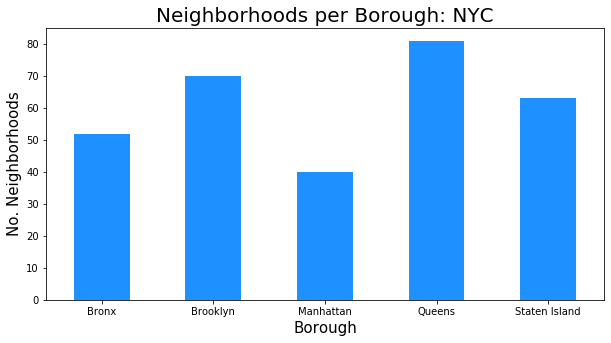

In [31]:
from matplotlib import pyplot as plt
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [32]:
# queens has most neighborhoods
# prepare neighborhood list that contains Italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    print(row)
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
['Bronx', '

In [33]:
italian_rest_ny.to_csv('italian_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [34]:
italian_rest_ny = pd.read_csv('italian_rest_ny_tocsv1.csv')
italian_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
207,207,Manhattan,Flatiron,53370455498e18d7e6607a1d,La Pizza & La Pasta
208,208,Queens,Sunnyside Gardens,5699aa86498ef437b2fd7102,Zio Luigi
209,209,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's
210,210,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's
211,211,Staten Island,Lighthouse Hill,5079ccdce4b065f1dd8155ad,Casa verde


In [35]:
italian_rest_ny.shape

(212, 5)

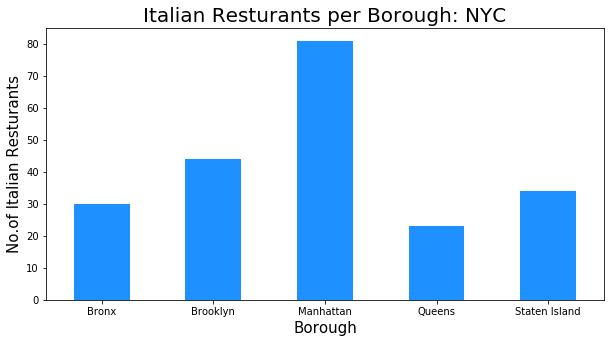

In [36]:
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Italian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

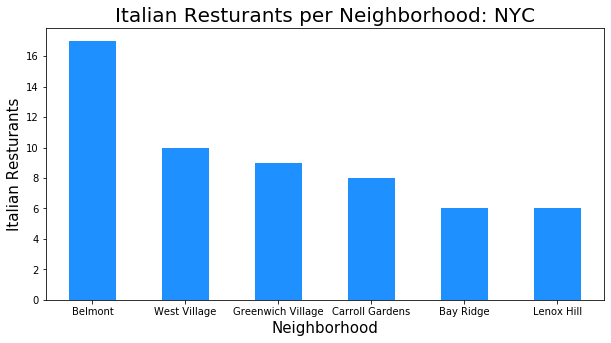

In [37]:
NOofNeigh = 6 # top number for graphing all the same past 6
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

So Belmont has the most Italian restaurants while Lenox Hill the least, so Veronica can save the hassel of going there at all. Veronica can also explore this area once she's done with the first Italian restaurant and continue her food journey!